In [4]:
import sys
sys.path.insert(1, '/home/maria/Documents/EnsemblePursuit')
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import seaborn as sns

In [72]:
data_path='/home/maria/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
U=np.load('U.npy')
input_patterns=S[np.nonzero(U[:,13])[0],:]
input_patterns=zscore(input_patterns,axis=1)
del spks
#del S

Shape of the data matrix, neurons by timepoints: (18795, 30766)


In [3]:
weights=np.load('/media/maria/DATA1/Documents/Neocortex/SOC/soc.txt.npy')

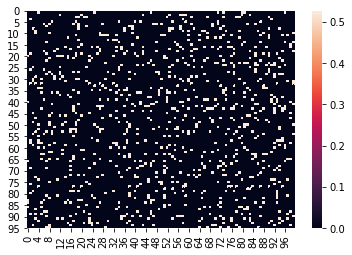

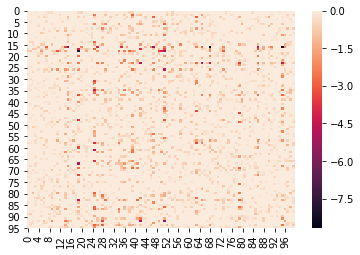

In [26]:
#Inhibitory sub-population
num_neurons=200
first_quadrant = np.arange(num_neurons/2)
second_quadrant = first_quadrant + num_neurons/2
first_quadrant=first_quadrant.astype('int')
second_quadrant=second_quadrant.astype('int')
W_IE = weights[np.ix_(second_quadrant,first_quadrant)]
W_II = weights[np.ix_(second_quadrant,second_quadrant)]
sns.heatmap(W_IE)
plt.show()
sns.heatmap(W_II)

(100, 30560)
9.961153e-10


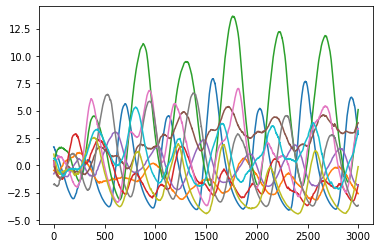

In [85]:
np.random.seed(7)
def gain_function(x):
    x[x<0]= 5*np.tanh(x[x<0]/5)
    '''
    if x<0:
        return 5*np.tanh(x/5)
    else:
        return (100-5)*np.tanh(x/(100-5))
    '''
    x[x>=0]=(100-5)*np.tanh(x[x>=0]/(100-5))
    return x
inh_weights=np.hstack((W_IE,W_II))
#inh_weights=np.random.normal(0,1,(100,200))
activity_pattern=[np.random.normal(0,1,(100,))]
print(input_patterns.shape)
h=0.01
for t in range(1,3000):
    #print(t)
    x=activity_pattern[-1].reshape(100,)
    #print('z',x.shape)
    inp=np.concatenate((input_patterns[:100,t].reshape(100,),x),axis=0)
    dxdt=(-x+gain_function(inh_weights@inp))
    #print('dxdt',dxdt.shape)
    activity_pattern.append(activity_pattern[-1]+h*dxdt.reshape(100,))
    #print(activity_pattern)
activity_patterns=np.array(activity_pattern).T
#print(activity_patterns.shape)
#print(activity_patterns)
plt.plot(activity_patterns[:10,:].T)
print(np.mean(input_patterns))

In [73]:
print(U.shape)
print(S.shape)

(18795, 200)
(18795, 30560)


(100, 30560)
-9.929947e-10
(100, 30560)


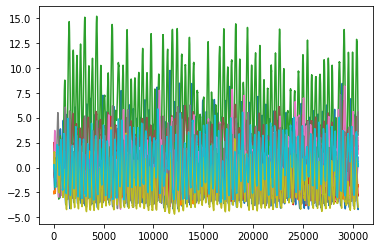

In [88]:
#inhibitory dynamics with input from neurons with dis-similar receptive fields
rand_neurons=np.random.randint(0,18795,size=(100,))
input_patterns=S[rand_neurons,:]
input_patterns=zscore(input_patterns,axis=1)
inh_weights=np.hstack((W_IE,W_II))
#inh_weights=np.random.normal(0,1,(100,200))
activity_pattern=[np.random.normal(0,1,(100,))]
print(input_patterns.shape)
h=0.01
for t in range(1,30560):
    #print(t)
    x=activity_pattern[-1].reshape(100,)
    #print('z',x.shape)
    inp=np.concatenate((input_patterns[:100,t].reshape(100,),x),axis=0)
    dxdt=(-x+gain_function(inh_weights@inp))
    #print('dxdt',dxdt.shape)
    activity_pattern.append(activity_pattern[-1]+h*dxdt.reshape(100,))
    #print(activity_pattern)
activity_patterns=np.array(activity_pattern).T
#print(activity_patterns.shape)
#print(activity_patterns)
plt.plot(activity_patterns[:10,:].T)
print(np.mean(input_patterns))
print(activity_patterns.shape)


In [92]:
#Do the inhibitory neurons in the sub-network have receptive fields?
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

v_lst=activity_patterns[0,:]
v_lst=np.array(zscore(v_lst))
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
ly, lx, nstim = mov.shape
#print(nstim)
NT = activity_patterns.shape[1]
NN=1
mov=mov[:,:,:NT]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ v_lst[itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, 1))
B0 = gaussian_filter(B0, [.5, .5, 0])

30560
